In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.collections
from scipy.interpolate import interp1d
sns.set()
from results import load
from matplotlib.lines import Line2D

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colorbar
from functions import *
#constants
experiment_phase = {'p0':60000, 'p1':60000, 'p2':180000}
experiment_phase_labels = [*experiment_phase]

#avoid Font-problem in plots for ACM/IEEE papers
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/home/b/projects/SACBench/functions.py:15: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from mpl_toolkits.axes_grid1.colorbar import colorbar


# Reading the results

In [2]:
#config
experiment_name = "acr"
all = None

all_new = load("acr", ["aws","gcf","ibm","azure"],["0,0,1","0,0,0.5","60,60,1","60,60,0.5","60,60,0"],2,True)
all_old = load("full", ["aws","gcf","ibm","azure"],["0,0,1","0,0,0.5","60,60,1","60,60,0.5","60,60,0"],2,True)
all_new_maf = load("low", ["azure"],["0,0,1","5,5,0","15,15,0","60,60,0"],2,True)

all = pd.concat([all_new,all_old,all_new_maf],ignore_index=True)
#this is important for phase based plots (leave it otherwise)
all = all[(all["Phase"] != "none")]
providers = all["Provider"].unique()
num_repetitions = 2
configs = all["WL"].unique()

print(configs,providers,all["Experiment"].unique())
all.columns

['0,0,1' '0,0,0.5' '60,60,1' '60,60,0.5' '60,60,0' '5,5,0' '15,15,0'] ['azure' 'gcf' 'aws' 'ibm'] ['acr' 'full' 'low']


Index(['RId', 'CIdOld', 'WL', 'CId', 'CStart', 'ECost', 'DLat', 'ELat',
       'RFailed', 'Phase', 'RStart', 'EStart', 'EEnd', 'REnd', 'CNew', 'CPlat',
       'TLat', 'COs', 'RInput', 'Provider', 'Region', 'RLat', 'BLat',
       'RResult', 'run', 'sourceFile', 'RCode', 'RSuccessed', 'HIdOld', 'HId',
       'Experiment', 'FOpt', 'PlatfromName', 'FEnv'],
      dtype='object')

### Styles and Constants

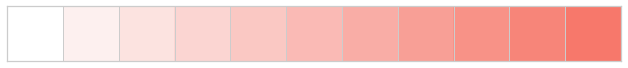

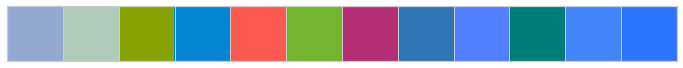

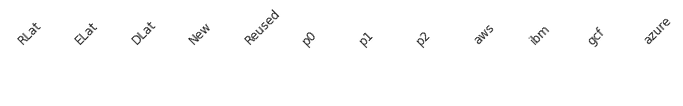

In [92]:
#sns.set_palette(sns.color_palette("Paired"))

palette = sns.color_palette().as_hex()
style = {
    "aws":{
        "name":"AWS",
        "color":"#527fff"#palette[8]
    },
    "ibm":{
        "name":"ICF",
        "color":"#007d79"#palette[1]
    },
    "gcf":{
        "name":"GCF",
        "color":"#4485f9"#palette[2]
    },
    "azure":{
        "name":"MAF",
        "color":"#2d75fe" ##fec21f palette[4]
    },
    "CNew":{
        "New":"#0485d1",
        "Cold":"#0485d1",
        "Reused": "#fc5a50",
        "Warm": "#fc5a50"
    },
    #colors
    "Lats":{
        "Delivery Latency":"#d1ffbd",
        "Request-Response Latency":"#92a8d1",
        "Execution Latency":"#B1cbbb",
        "Backward Response Delivery Latency":"#89a203",
        "Delivery":"#89a203",
        "Delivery Latency":"#89a203",
        "Request-Response":"#92a8d1",
        "Execution":"#B1cbbb",
        "Backward Response Delivery":"#89a203",
        "DLat":"#89a203",
        "BLat":"#89a203",
        "RLat":"#92a8d1",
        "ELat":"#B1cbbb",
        "Failiur":"#DC1E1E"
    },
    "Phases":{
        "p0":"#74B52F",
        "p2":"#2F74B5",
        "p1":"#B52F74",
        "warmup":"#74B52F",
        "cooldown":"#2F74B5",
        "scaling":"#B52F74"
    },
    #Strings
    "Names":{
        "DLat":"Delivery Latency",
        "RLat":"Request-Response Latency",
        "ELat":"Execution Latency",
        "BLat":"Backward Response Delivery Latency",
        "p0":"warmup",
        "p1":"scaling",
        "p2":"cooldown",
        "HId":"VM",
        "CId":"Container",
        "HIdOld":"VM (old method)",
        "full":"SAC2020",
        "acr":"ACR2020",
        "low":"ACR2020",
        "WL":"Workload",
        "Provider":"Provider",
        "Phase":"Phase"
    },
    "Workloads":{
        '0,0,1':"WL1",
        '0,0,0.5':"WL0",
        '60,60,1':"WL4",
        '60,60,0.5':"WL3",
        '60,60,0':"WL5",
        '5,5,0':"WL6",
        '15,15,0':"WL7",
        '0,0,2':"WL2"
    }
    
}

hmcmp = [(1,1,1,1),(0.996,0.945,0.941,1),(0.992,0.894,0.882,1),(0.988,0.839,0.824,1),(0.984,0.788,0.765,1),(0.984,0.733,0.710,1),(0.980,0.682,0.651,1),(0.976,0.627,0.592,1),(0.973,0.576,0.533,1),(0.969,0.522,0.475,1),(0.969,0.471,0.42,1),]

sns.set(style="whitegrid")
plotStyle(style,hmcmp)

# Masterplot V4

In [4]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
all_280 = all[all["EStart"].isna() | all["EStart"] < 280000 ]
all_280 = all_280[all_280["run"]==1]
#Latency Limits
default = [0,30]
ylims = {
    "aws":
    {"0,0,0.5":[0,3],"0,0,1":[0,6],"60,60,0.5":[0,6],"60,60,1":[0,6],"60,60,0":[0,6]},
    "ibm":
    {"0,0,0.5":default,"0,0,1":default,"60,60,0.5":default,"60,60,1":default,"60,60,0":default},
    "azure":
    {"0,0,0.5":default,"0,0,1":[0,40],"60,60,0.5":default,"60,60,1":default,"60,60,0":default,"5,5,0":default,"15,15,0":default},
    "gcf":
    {"0,0,0.5":default,"0,0,1":default,"60,60,0.5":default,"60,60,1":default,"60,60,0":default},
    "workload":
    {"0,0,0.5":[0,120],"0,0,1":[0,120],"60,60,0.5":[0,120],"60,60,1":[0,120],"60,60,0":[0,120],"5,5,0":[0,120],"15,15,0":[0,120]},
}
#Heatmap obergrenze
vmax=15
#Heatmap VM-cutoff (VMs mit weniger als x [%] auslastung  ) Reduziert verticale dichte und rechenzeit
cutoff=0.1

In [12]:
def diffPlot(data_280,workload,provider,fname,experiment=("acr","full"),title=True,hplot=True):
    
    def order():
        if hplot:
            return iter([(0,0),(0,1),(1,0),(1,1)])
        else:
            return iter([(0,0),(1,0)])
    
    placement = order()
    
    #setup subfigures (4 if we show two experiments otherwise just 2 stacked)
    cols = 2
    if experiment[1] is None:
        cols = 1   
    if not hplot:
        cols = 1
        
    #setup figure
    fig = plt.figure(figsize=(6*cols,11))
    gs = fig.add_gridspec(ncols=cols, nrows=2,wspace=0.3,hspace=0.45)
    
    def place():
        p = next(placement)
        return gs[p[0],p[1]]
    
    if title:
        plt.suptitle("Results for {} - {}".format(style["Workloads"][workload],style[provider]["name"]), fontsize=16,y=1.08)
    
    exp = experiment[0]
    data = all_280[all_280["Experiment"]==exp]
    ax = fig.add_subplot(place())
    plotClientSideOverview(ax,data,provider,workload,style=style,ylim=ylims[provider][workload],
                           xlim=[0,280],with_thruput=True,legend=False,
                           title="{}\nClient-side Impacts".format(style["Names"][exp]))
    #fix y-axis
    ax.set_ylim(ylims["workload"][workload])

    
    if experiment[1] is not None:
        data = all_280[all_280["Experiment"]==experiment[1]]
        ax = fig.add_subplot(place())
        plotClientSideOverview(ax,data,provider,workload,style=style,ylim=ylims[provider][workload],
                               xlim=[0,280],with_thruput=True,legend=False,
                               title="{}\nClient-side Impacts".format(style["Names"]["full"]))
        ax.set_ylim(ylims["workload"][workload])
    
    if hplot:
        data = all_280[all_280["Experiment"]==exp]
        ax = fig.add_subplot(place())
        plotHeatmap(ax,data,provider,workload,style,selector="HId",cutoff=cutoff,xlim=[0,280],
                    legend=False,title="Provider-side Impacts",cmap=hmcmp,vmax=vmax,heatmap_cache={})
        for _, spine in ax.spines.items():
            spine.set_visible(True)

        if experiment[1] is not None:
            data = all_280[all_280["Experiment"]==experiment[1]]
            ax = fig.add_subplot(place())
            plotHeatmap(ax,data,provider,workload,style,selector="HId",cutoff=cutoff,xlim=[0,280],
                        legend=False,title="Provider-side Impacts",cmap=hmcmp,vmax=vmax,heatmap_cache={})
            for _, spine in ax.spines.items():
                spine.set_visible(True)
    
    #create legend by hand
    legendShapes = [
                    Line2D([0], [0], color="gray", lw=2),
                    Line2D([0], [0], marker='.',color=style[provider]["color"], lw=0, markersize=10),
                    Line2D([0], [0], marker='+', lw=0,color='indianred',markerfacecolor='indianred', markersize=10),
                    Line2D([0], [0], color=style["Lats"]["RLat"], lw=4),
                    Line2D([0], [0], color=style["Lats"]["ELat"], lw=4),
                ]
    legendNames = ["Target Throughput","Measured Throughput","Failed Requests",style["Names"]["RLat"],style["Names"]["ELat"]]
    if hplot:
        legendShapes.append(Line2D([0], [0], marker='|', lw=0,color='blue',markerfacecolor='blue', markersize=20))
        legendNames.append("First VM Occurrence")
    #legen placement this depends on the figsize..
    if cols > 1:
        plt.figlegend(legendShapes, legendNames,
            loc='upper right',fancybox=True, shadow=True, ncol=2, bbox_to_anchor=(0.125, 0.51, 0.5, 0.5))
    else:
        plt.figlegend(legendShapes, legendNames,
            loc='upper right',fancybox=True, shadow=True, ncol=2, bbox_to_anchor=(0.125, 0.51,0.76, 0.5))
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')

(0, 0)
(0, 1)
(1, 0)
(1, 1)
(0, 0)
(0, 1)
(1, 0)
(1, 1)
(0, 0)
(0, 1)
(1, 0)
(1, 1)


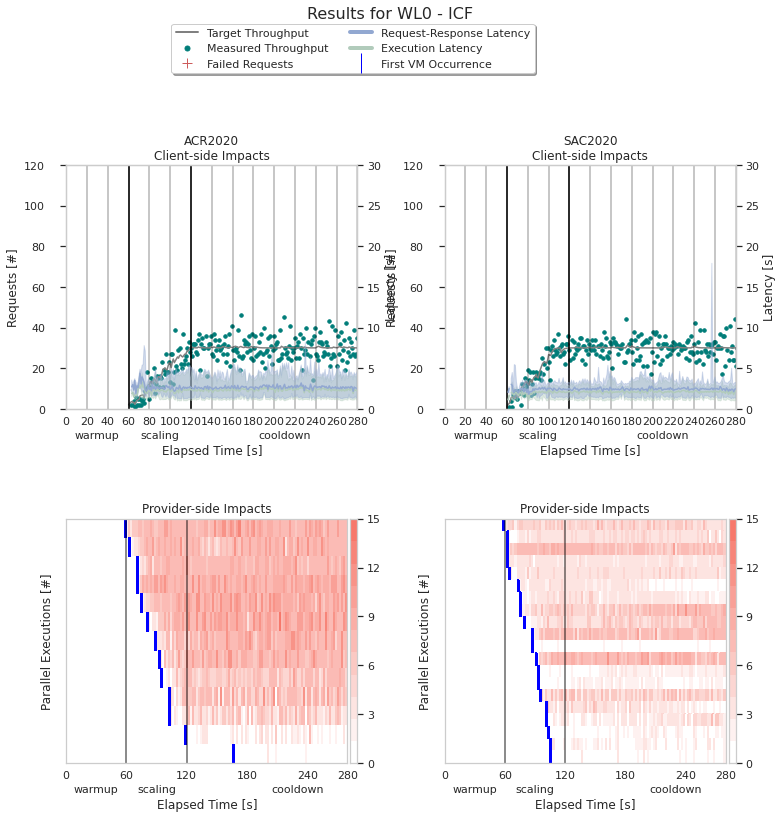

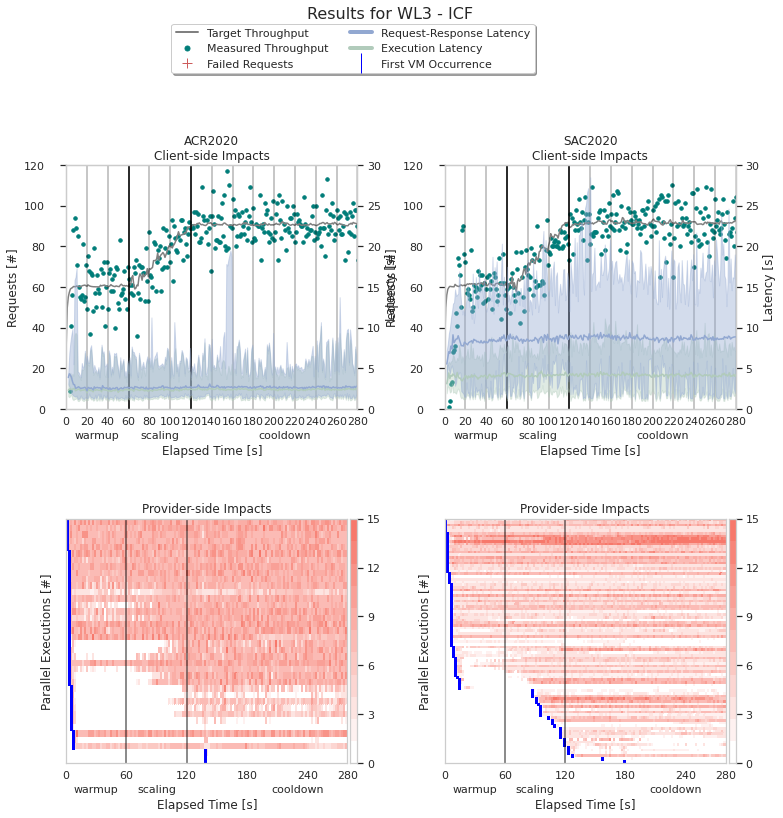

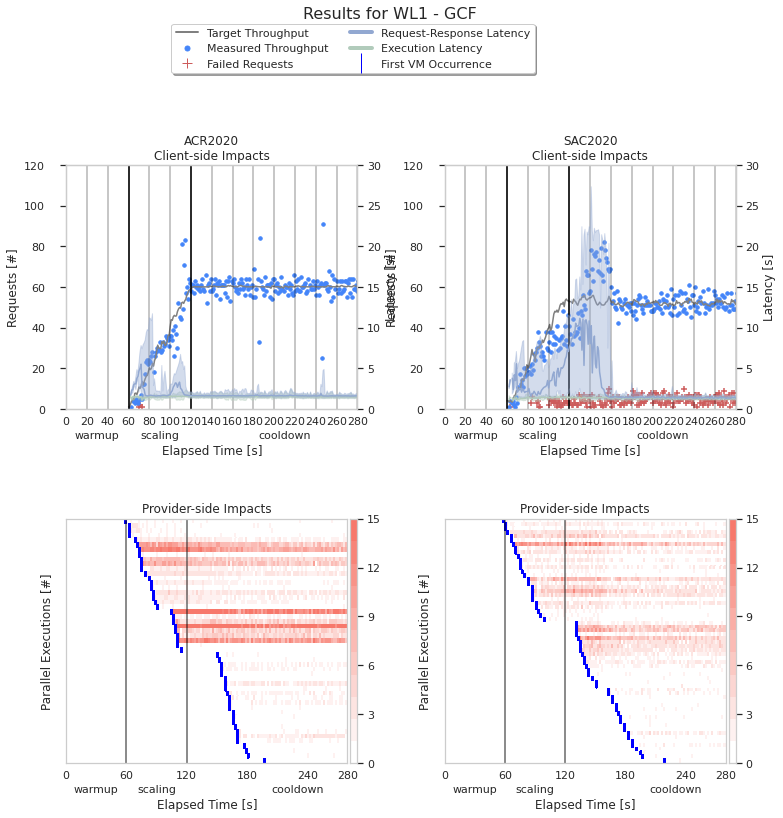

In [14]:
#diffPlot(all_280,"5,5,0","azure","plots/maf.pdf",("low",None))
diffPlot(all_280,"0,0,0.5","ibm","plots/ibm-0,0,0.5.pdf")
diffPlot(all_280,"60,60,0.5","ibm","plots/ibm-60,60,0.5.pdf")
diffPlot(all_280,"0,0,1","gcf","plots/gcf.pdf")

## Table

In [129]:
def q(x,name):
    def _q(n):
        return np.percentile(n,x)
    _q.__name__ = name
    return _q

def count(n):
    return len(n)

def count_failed(n):
    return np.count_nonzero(n)
def percentage(n):
    return count_failed(n)/count(n)


#caution overly complicated magic function... is supposed to rename the index to the paper names ;)
#assumtion first to colums are provider and workload 
def reindex(df):
    values = df.index.values
    names = df.index.names
    new_values = []
    multidimensional = True
    for value in values:
        if type(value) is tuple:
            new_value = []
            new_value.append(style[value[0]]['name'])
            new_value.append(style["Workloads"][value[1]])
            for i in range(2,len(value)):
                new_value.append(value[i])
                
            new_values.append(tuple(new_value))
        else:
            multidimensional = False
            new_values.append(style[value]['name'])
    new_names = []
    for name in names:
        new_names.append(style["Names"][name])
        
    #print(df.index,new_values,new_names)
    if multidimensional:
        df.index=pd.MultiIndex.from_tuples(new_values,names=new_names)
    else:
        df.index=pd.Index(new_values,name=new_names[0])
    return df

count.__name__ = "Requests"
count_failed.__name__="Failed Requests"
percentage.__name__="Failed [%]"

def paperDataSet(data,providers,workloads,runs):
    data = data[data["Provider"].isin(providers)]
    data = data[data["WL"].isin(workloads)]
    data = data[data["run"].isin(runs)]
    return data

def createMetrics(data,providers,workloads,runs,group_key=["Provider","WL"]):
    #filter data
    data = paperDataSet(data,providers,workloads,runs)
    return metcisFromData(data,group_key)
    
def metcisFromData(data,group_key=["Provider","WL"]):
    #create performance metrics
    perf = data[data["RFailed"]==False].groupby(group_key)[["RLat","ELat"]].agg([np.median,q(90,"p90"),q(99,"p99"),np.max,np.mean])

    reliability = data.groupby(group_key)["RFailed"].agg([count,count_failed,percentage])
    
    reliability.columns = pd.MultiIndex.from_tuples([('Reliablity','Req [#]'),('Reliablity','Failed [#]'),('Reliablity','Failed [#]')])
    
    rlat = style["Names"]["RLat"]+' [s]'
    elat = style["Names"]["ELat"]+' [s]'
    perf.columns = pd.MultiIndex.from_tuples([
        (rlat, 'Med'),
        (rlat, '90-p'),
        (rlat, '99-p'),
        (rlat, 'Max'),
        (rlat, 'Mean'),
        (elat, 'Med'),
        (elat, '90-p'),
        (elat, '99-p'),
        (elat, 'Max'),
        (elat, 'Mean')
    ])
    reindex(perf)
    reindex(reliability)
    
    return perf,reliability

In [109]:
p_old,r_old = createMetrics(all_old,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1])
p_new,r_new = createMetrics(all_new,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1])

#generate diff
perf = p_old-p_new
reliability = r_old-r_new

df = pd.concat([reliability,perf],axis=1)


pd.options.display.float_format = "{:,.4f}".format
with open('plots/diff.tex', 'w') as f:
    f.write(df.to_latex())
df

Reliablity                        \
                     Req [#] Failed [#] Failed [#]   
Provider Workload                                    
AWS      WL0             -27          0     0.0000   
         WL1             -32          0     0.0000   
         WL3             242          0     0.0000   
         WL4             265       2642     0.0848   
GCF      WL0             -69          0     0.0000   
         WL1          -14392        869     0.0793   
         WL3             246          0     0.0000   
         WL4             273       2610     0.0838   
ICF      WL0             -35          0     0.0000   
         WL1             -22          0     0.0000   
         WL3             260          0     0.0000   
         WL4             291      -2442    -0.0790   

                  Request-Response Latency [s]                           \
                                           Med    90-p    99-p      Max   
Provider Workload                                                         
AWS      WL0                            0.0100  0.0040 -0.0180  -0.2910   
         WL1                            0.0200  0.0100 -0.1422  -0.3500   
         WL3                            0.0160 -0.0040 -0.2583  -3.5380   
         WL4                            0.0150 -0.0110 -0.3030  -0.2690   
GCF      WL0                           -0.0680  0.9089  8.3159  13.0770   
         WL1                           -0.1030  6.2646 12.6693  15.6010   
         WL3                           -0.0500  0.0220  5.5240  10.5230   
         WL4                           -0.0990 -0.1710 -0.0362   0.5260   
ICF      WL0                           -0.2070 -0.5871 -1.1312   9.6950   
         WL1                           -0.0880 -0.2790 -1.7443 -13.9230   
         WL3                            5.9960  7.6982  9.8508   8.9920   
         WL4                            6.1400  8.4774 11.6700  18.3840   

                          Execution Latency [s]                          \
                     Mean                   Med    90-p    99-p     Max   
Provider Workload                                                         
AWS      WL0       0.0105               -0.0120 -0.0170  0.0305  0.3440   
         WL1       0.0153                0.0030 -0.0030 -0.0510 -0.3780   
         WL3       0.0048                0.0040 -0.0030  0.0160 -0.5430   
         WL4       0.0021                0.0060  0.0050 -0.1092 -0.3910   
GCF      WL0       0.3513               -0.0840 -0.0360 -0.1172  0.2460   
         WL1       1.2454               -0.1670 -0.1730 -0.3752 -0.5390   
         WL3       0.1220               -0.0450 -0.0130  0.0730 -0.0980   
         WL4      -0.1417               -0.0780 -0.0919 -0.2114 -0.2520   
ICF      WL0      -0.2400               -0.2550 -0.5790 -1.0212 -1.0420   
         WL1      -0.1542               -0.1400 -0.2993 -1.6137 -4.5280   
         WL3       5.9988                1.7510  2.4740  2.5735  0.6110   
         WL4       6.3775                1.7830  2.6743  3.2980  5.6790   

                           
                     Mean  
Provider Workload          
AWS      WL0      -0.0114  
         WL1      -0.0003  
         WL3       0.0040  
         WL4       0.0054  
GCF      WL0      -0.1068  
         WL1      -0.1861  
         WL3      -0.0450  
         WL4      -0.1151  
ICF      WL0      -0.2812  
         WL1      -0.1890  
         WL3       1.7410  
         WL4       1.8478

In [111]:
p_old,r_old  = createMetrics(all_old,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1],["Provider"])
p_new,r_new = createMetrics(all_new,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1],["Provider"])

In [112]:
#Failiur Global
pd.concat([r_new,p_new],axis=1)

Reliablity                       Request-Response Latency [s]         \
            Req [#] Failed [#] Failed [#]                          Med   90-p   
Provider                                                                        
AWS           74519          0     0.0000                       1.6970 1.7680   
GCF           87170          4     0.0000                       1.5850 1.7810   
ICF           74512       2464     0.0331                       2.6470 3.5280   

                               Execution Latency [s]                        \
           99-p     Max   Mean                   Med   90-p   99-p     Max   
Provider                                                                     
AWS      2.1610  5.9180 1.7121                1.6350 1.6830 1.8788  2.5150   
GCF      2.4790 11.7020 1.6110                1.4640 1.5990 1.9450  2.5190   
ICF      5.7095 22.5210 2.7568                2.3690 3.1300 4.8726 10.5170   

                 
           Mean  
Provider         
AWS      1.6381  
GCF      1.4569  
ICF      2.4320

In [108]:
d_new = paperDataSet(all_new,["aws","gcf","ibm"],["0,0,0.5","0,0,1","60,60,1","60,60,0.5"],[1])

d_new = d_new[d_new["Phase"].isin(["p1","p2","p3"])]
hostview = d_new.groupby(["Provider","WL","Phase"])[["HId","CId"]].agg('nunique')
reindex(hostview)

HId  CId
Provider Workload Phase          
AWS      WL0      p1      53   53
                  p2      64   64
         WL1      p1     105  105
                  p2     114  114
         WL3      p1     160  160
                  p2     211  211
         WL4      p1     214  214
                  p2     275  275
GCF      WL0      p1      43   73
                  p2      69  118
         WL1      p1      28  127
                  p2      51  163
         WL3      p1      36  230
                  p2      37  231
         WL4      p1      30  210
                  p2      78  302
ICF      WL0      p1      12  100
                  p2      13  198
         WL1      p1      23  189
                  p2      25  288
         WL3      p1      34  295
                  p2      38  484
         WL4      p1      44  384
                  p2      50  626

In [115]:
d_new = d_new[d_new["Phase"].isin(["p1","p2","p3"])]
hostview = d_new.groupby(["Provider","Phase"])[["HId","CId"]].agg(['nunique'])
#reindex(hostview)
hostview

HId   CId
Provider Phase           
aws      p1     434   434
         p2     553   553
gcf      p1     135   637
         p2     231   808
ibm      p1      44   968
         p2      50  1596

In [132]:
d_maf = paperDataSet(all_new_maf,["azure"],["5,5,0","0,0,1","15,15,0"],[1])
d_maf.loc[d_maf["RLat"] > 30,"RFailed"] = True
p_maf,r_maf = metcisFromData(d_maf)#,group_key=["Provider"])
pd.concat([r_maf,p_maf],axis=1)

Reliablity                        \
                     Req [#] Failed [#] Failed [#]   
Provider Workload                                    
MAF      WL1           12654      12534     0.9905   
         WL7            4574       1697     0.3710   
         WL6            1505         76     0.0505   

                  Request-Response Latency [s]                          \
                                           Med    90-p    99-p     Max   
Provider Workload                                                        
MAF      WL1                            7.5200 27.8019 29.5968 29.8840   
         WL7                           13.9470 25.9802 29.4480 29.9960   
         WL6                            4.0080 11.8940 23.2934 29.6650   

                          Execution Latency [s]                                 
                     Mean                   Med    90-p    99-p     Max   Mean  
Provider Workload                                                               
MAF      WL1      12.4576                3.2250 26.4618 28.9888 29.0810 7.4628  
         WL7      14.2807                2.9030  3.5770  4.5389 28.7610 3.0288  
         WL6       6.0447                2.8590  3.5762  4.2546  6.4750 2.9731

In [138]:
d_maf = d_maf[d_maf["Phase"].isin(["p1","p2","p3"])]
d_maf.groupby(["Provider","WL","Phase"])[["HId","CIdOld"]].agg(['nunique'])

HId  CIdOld
                     nunique nunique
Provider WL    Phase                
azure    0,0,1 p1         72      72
               p2         10      10
         5,5,0 p1         19      19
               p2         22      22

In [137]:
d_maf["CId"].unique()

array(['sls-uks-dev-tub-elasticity-benchmark.azurewebsites.net', nan],
      dtype=object)